In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
toxprot_17 = pd.read_csv('../data/processed/toxprot_2017.csv')
toxprot_25 = pd.read_csv('../data/processed/toxprot_2025.csv')

In [13]:
def change_protfams(df):
    df['Protein families'] = df['Protein families'].str.split(',').str[0]
    df['Protein families'] = df['Protein families'].str.split(';').str[0]

    df['Protein families'] = df['Protein families'].replace('I1 superfamily', 'Conotoxin I1 superfamily')
    df['Protein families'] = df['Protein families'].replace('O1 superfamily', 'Conotoxin O1 superfamily')
    df['Protein families'] = df['Protein families'].replace('O2 superfamily', 'Conotoxin O2 superfamily')
    df['Protein families'] = df['Protein families'].replace('E superfamily', 'Conotoxin E superfamily')
    df['Protein families'] = df['Protein families'].replace('F superfamily', 'Conotoxin F superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin M family', 'Conotoxin M superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin B2 family', 'Conotoxin B2 superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin O1 family', 'Conotoxin O1 superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin O2 family', 'Conotoxin O2 superfamily')

    return df
change_protfams(toxprot_17)
change_protfams(toxprot_25)

,Entry,Organism,Protein families,Length,Fragment,Toxic dose,PTM
0,A0A068B6Q6,Conus betulinus (Beech cone),Conotoxin A superfamily,37,fragment,NaN,NaN
1,A0A088MIT0,Physalaemus nattereri (Cuyaba dwarf frog) (Eup...,Frog skin active peptide (FSAP) family,134,NaN,NaN,NaN
2,A0A0A1I6E7,Androctonus crassicauda (Arabian fat-tailed sc...,Non-disulfide-bridged peptide (NDBP) superfamily,74,NaN,NaN,NaN
3,A0A0A1I6N9,Androctonus crassicauda (Arabian fat-tailed sc...,Non-disulfide-bridged peptide (NDBP) superfamily,74,NaN,NaN,NaN
4,A0A0B4U9L8,Vipera ammodytes ammodytes (Western sand viper),Venom metalloproteinase (M12B) family,614,NaN,NaN,PTM: N-glycosylated. {ECO:0000269|PubMed:25549...
...,...,...,...,...,...,...,...
8050,P86344,Brotheas amazonicus (Scorpion),NaN,10,fragment,NaN,NaN
8051,P86827,Tityus serrulatus (Brazilian scorpion),Non-disulfide-bridged peptide (NDBP) superfamily,7,NaN,NaN,NaN
8052,Q45RU8,Conus striatus (Striated cone),NaN,44,fragment,NaN,PTM: Contains 3 disulfide bonds. {ECO:0000305}.
8053,Q7M463,Olivierus martensii (Manchurian scorpion) (Mes...,NaN,29,NaN,NaN,PTM: Contains 3 disulfide bonds. {ECO:0000305}.


In [14]:
toxprot_17['Protein families'].value_counts()

Protein families
Snake three-finger toxin family            505
Phospholipase A2 family                    498
Long (4 C-C) scorpion toxin superfamily    338
Venom metalloproteinase (M12B) family      270
Huwentoxin-1 family                        251
                                          ... 
AhpC/TSA family                              1
Scolopendra toxin 9 family                   1
Scolopendra toxin 7 family                   1
Scolopendra toxin 6 family                   1
Peptidase S10 family                         1
Name: count, Length: 191, dtype: int64

In [15]:
toxprot_25['Protein families'].value_counts()

Protein families
Phospholipase A2 family                    543
Snake three-finger toxin family            536
Long (4 C-C) scorpion toxin superfamily    426
Neurotoxin 10 (Hwtx-1) family              290
Venom metalloproteinase (M12B) family      286
                                          ... 
Scolopendra toxin 9 family                   1
ATP:guanido phosphotransferase family        1
Diapausin family                             1
DNase II family                              1
SLPTX(15) family                             1
Name: count, Length: 304, dtype: int64

### Figures

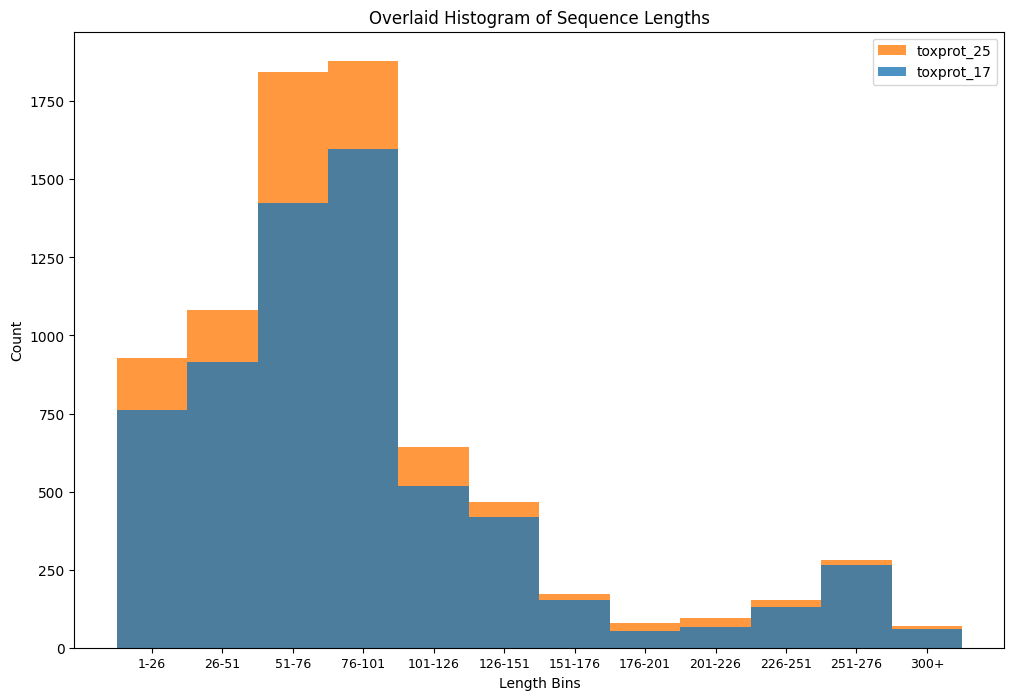

In [40]:
bins = np.arange(1, 325, 25)

bin_labels = [f"{start}-{end}" for start, end in zip(bins[:-1], bins[1:])]
bin_labels[-1] = "300+"

lengths_25 = toxprot_25["Length"]
lengths_17 = toxprot_17["Length"]

plt.figure(figsize=(12, 8))
plt.hist(lengths_25, bins=bins, alpha=0.8, color=plt.cm.tab10(1), label="toxprot_25")
plt.hist(lengths_17, bins=bins, alpha=0.8, color=plt.cm.tab10(0), label="toxprot_17")

plt.xlabel("Length Bins")
plt.ylabel("Count")
plt.title("Overlaid Histogram of Sequence Lengths")

plt.xticks(bins[:-1] + 12.5, bin_labels, fontsize=9)

plt.legend()
plt.savefig("../figures/overlaid_hist.png", dpi=300)

plt.show()
plt.close()

/var/folders/6k/gr_1_h_97154rq71pm_q3jn40000gn/T/ipykernel_7911/1707386889.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_families))


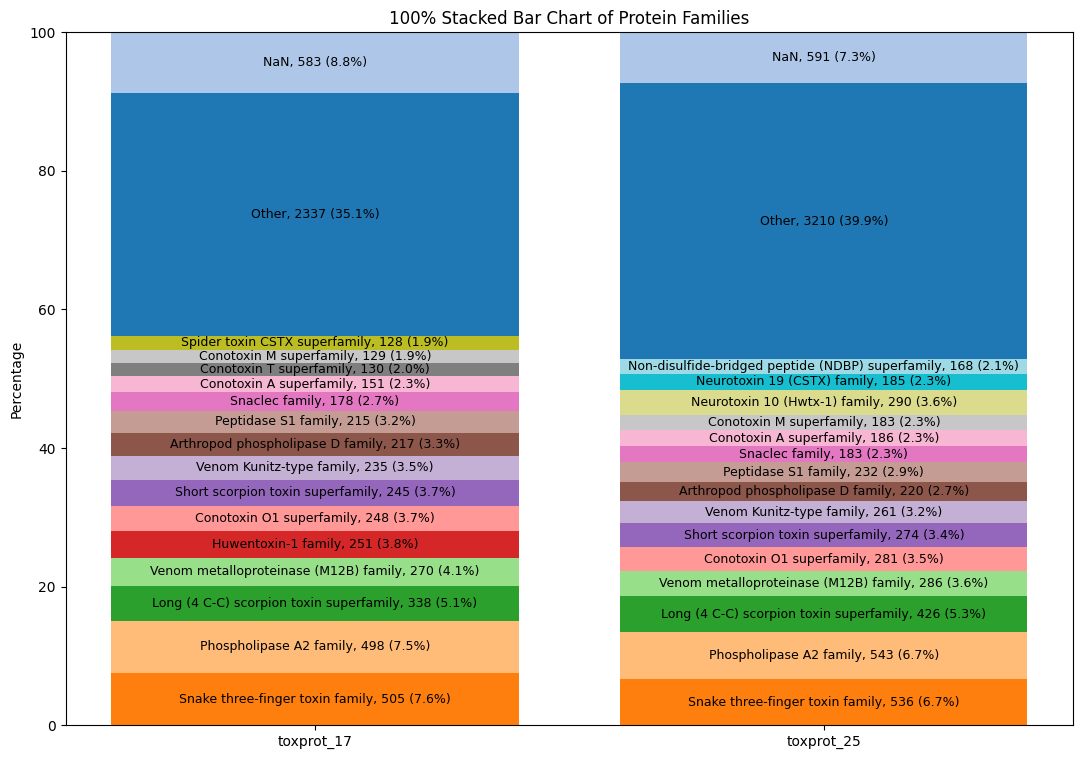

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def get_all_families(df1, df2, column, top_n=15):
    counts_1 = df1[column].value_counts()
    counts_2 = df2[column].value_counts()

    top_counts_1 = counts_1.nlargest(top_n)
    top_counts_2 = counts_2.nlargest(top_n)

    other_counts_1 = counts_1.drop(top_counts_1.index).sum()
    other_counts_2 = counts_2.drop(top_counts_2.index).sum()

    all_families = pd.concat([top_counts_1, top_counts_2], axis=1, keys=["toxprot_17", "toxprot_25"]).fillna(0)
    all_families.loc["Other"] = [other_counts_1, other_counts_2]

    nan_count_17 = df1[column].isna().sum()
    nan_count_25 = df2[column].isna().sum()
    if nan_count_17 > 0 or nan_count_25 > 0:
        all_families.loc["NaN"] = [nan_count_17, nan_count_25]

    return all_families

df_stacked = get_all_families(toxprot_17, toxprot_25, "Protein families", top_n=15)

df_stacked_perc = df_stacked.div(df_stacked.sum()) * 100

fig, ax = plt.subplots(figsize=(13, 9))
bottom = np.zeros(2)

unique_families = list(df_stacked_perc.index)

colors = plt.cm.get_cmap("tab20", len(unique_families))

color_map = {family: colors(i+2) for i, family in enumerate(unique_families)}
color_map["Other"] = colors(0)
color_map["NaN"] = colors(1)

for i, (family, values) in enumerate(df_stacked_perc.iterrows()):
    bars = ax.bar(["toxprot_17", "toxprot_25"], values, bottom=bottom, color=color_map[family])

    abs_values = df_stacked.loc[family]

    for bar, val_abs, val_perc in zip(bars, abs_values, values):
        if val_abs > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{family}, {int(val_abs)} ({val_perc:.1f}%)",
                ha="center", va="center", fontsize=9, color="black", wrap=True
            )

    bottom += values

ax.set_ylabel("Percentage")
ax.set_title("100% Stacked Bar Chart of Protein Families")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 100)

plt.savefig("../figures/stacked_bar_protfam.png", dpi=300)

plt.show()
plt.close()